In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os

os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

 96% 61.0M/63.2M [00:00<00:00, 128MB/s]
100% 63.2M/63.2M [00:00<00:00, 107MB/s]


In [10]:
!unzip /content/age-gender-and-ethnicity-face-data-csv.zip -d content/

Archive:  /content/age-gender-and-ethnicity-face-data-csv.zip
  inflating: content/age_gender.csv  


### Dataset
https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf

In [12]:
data = pd.read_csv('/content/content/age_gender.csv')
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [13]:
data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(),dtype="float32"))


In [14]:
print('first image shape', data['pixels'][0].shape)
print('shape of all images', data['pixels'].shape)

first image shape (2304,)
shape of all images (23705,)


In [15]:
X = np.zeros((23705,2304))
for i in range(len(data["pixels"])):
    X[i] = data["pixels"][i]
print(X.shape)

(23705, 2304)


In [16]:
X = X.reshape(-1,48,48,1)
print(X.shape)

(23705, 48, 48, 1)


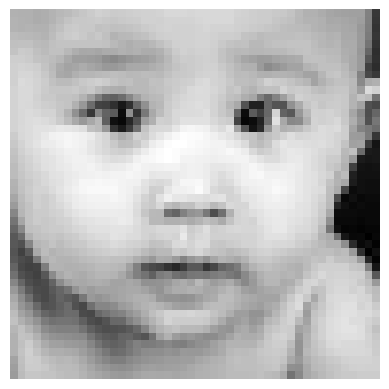

In [17]:
def show_pic(img):
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()

show_pic(X[0])

In [18]:
data.describe()

,age,ethnicity,gender
count,23705.000000,23705.000000,23705.000000
mean,33.300907,1.269226,0.477283
std,19.885708,1.345638,0.499494
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,1.000000,0.000000
75%,45.000000,2.000000,1.000000
max,116.000000,4.000000,1.000000


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [40]:
y_age = tf.keras.utils.to_categorical(data['age']//10, num_classes=104)
print(y_age.shape)
print(np.unique(y_age))

(23705, 104)
[0. 1.]


In [21]:
y_gender = data['gender']
y_gender.shape

(23705,)

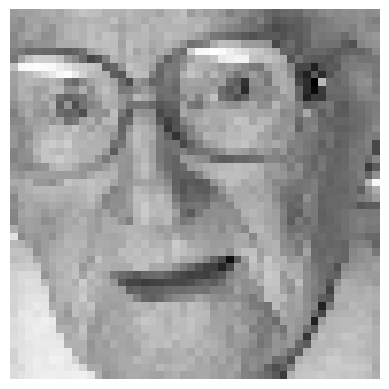

In [22]:
show_pic(X[-1])

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc_gender = ModelCheckpoint('/content/drive/MyDrive/gender.h5', monitor='val_accuracy', mode='max', save_best_only=True)
mc_age = ModelCheckpoint('//content/drive/MyDrive/age.h5', monitor='val_accuracy', mode='max', save_best_only=True)

input_shape = (48, 48, 1)

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout

def get_model(output_units: int, activation: str, loss: str, metrics: str):
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))

  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D((2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D((2,2)))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(output_units, activation=activation))
  model.compile(optimizer='adam', 
                loss= loss,
                metrics = metrics
                )
  model.summary()
  return model

In [48]:
def plot_loss_accuracy(history):
    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

In [41]:
from sklearn.model_selection import train_test_split

X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X, y_gender, test_size=0.2, random_state=42, shuffle=True)
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, y_age, test_size=0.2, random_state=42, shuffle=True)

In [65]:
gender_model = get_model(1, 'sigmoid', 'binary_crossentropy', 'accuracy')
history_gender = gender_model.fit(X_train_gender, y_train_gender, epochs=20, validation_data=(X_test_gender, y_test_gender), verbose=1, batch_size=32, callbacks=[es,mc_gender])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_45 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 dropout_36 (Dropout)        (None, 21, 21, 64)        0         
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 10, 10, 64)      

In [61]:
age_model = get_model(104, 'softmax', 'categorical_crossentropy', 'accuracy')
age_history = age_model.fit(X_train_age, y_train_age, epochs=20, validation_data=(X_test_age, y_test_age), verbose=1,callbacks=[mc_age])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_40 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 dropout_32 (Dropout)        (None, 21, 21, 64)        0         
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 10, 10, 64)      

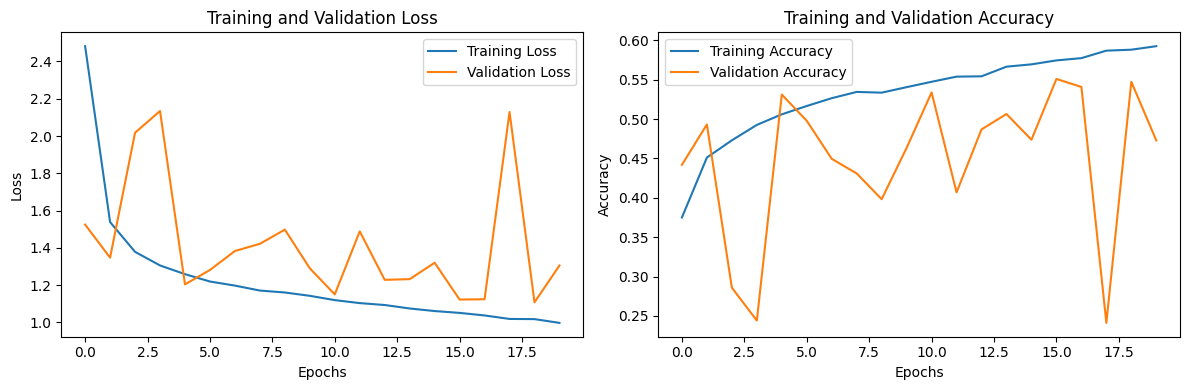

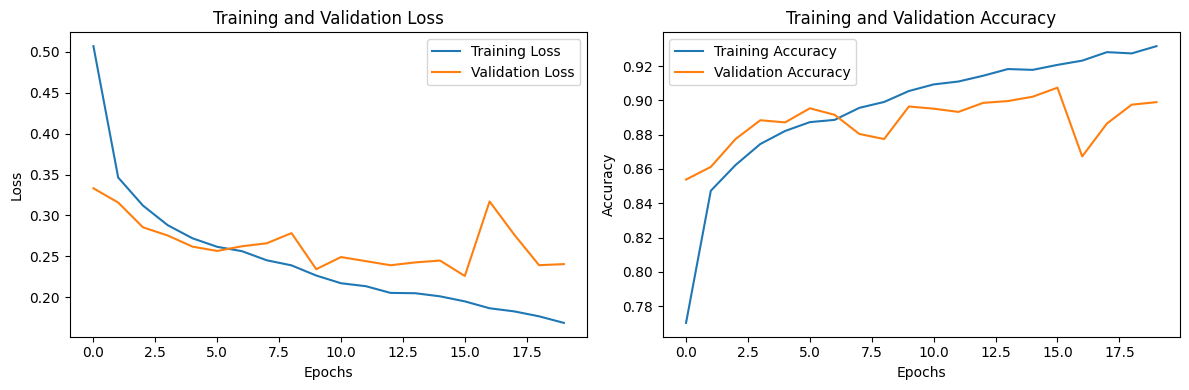

In [67]:
plot_loss_accuracy(age_history)
plot_loss_accuracy(history_gender)

Epoch 1/20
297/297 [==============================] - 6s 12ms/step - loss: 2.9260 - dense_age_loss: 2.2465 - dense_gender_loss: 0.6795 - dense_age_accuracy: 0.3827 - dense_gender_accuracy: 0.7571 - val_loss: 1.9147 - val_dense_age_loss: 1.5298 - val_dense_gender_loss: 0.3849 - val_dense_age_accuracy: 0.4478 - val_dense_gender_accuracy: 0.8300
Epoch 2/20
297/297 [==============================] - 2s 8ms/step - loss: 1.8222 - dense_age_loss: 1.4550 - dense_gender_loss: 0.3672 - dense_age_accuracy: 0.4530 - dense_gender_accuracy: 0.8394 - val_loss: 1.7337 - val_dense_age_loss: 1.3670 - val_dense_gender_loss: 0.3667 - val_dense_age_accuracy: 0.4725 - val_dense_gender_accuracy: 0.8424
Epoch 3/20
297/297 [==============================] - 2s 7ms/step - loss: 1.6788 - dense_age_loss: 1.3509 - dense_gender_loss: 0.3280 - dense_age_accuracy: 0.4812 - dense_gender_accuracy: 0.8547 - val_loss: 1.6401 - val_dense_age_loss: 1.3251 - val_dense_gender_loss: 0.3150 - val_dense_age_accuracy: 0.4769 - v

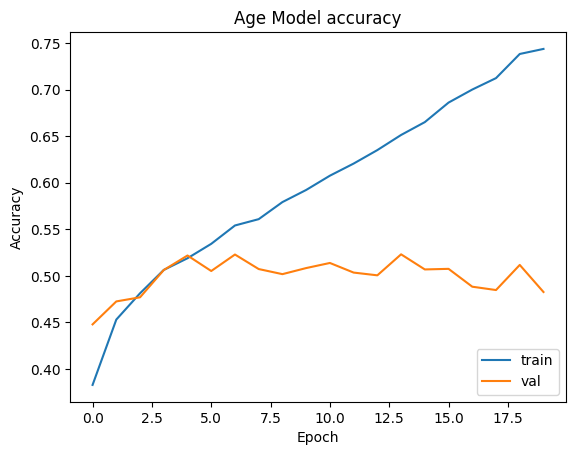

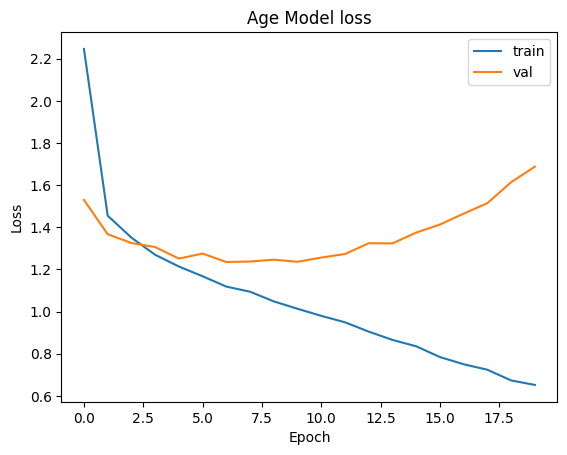

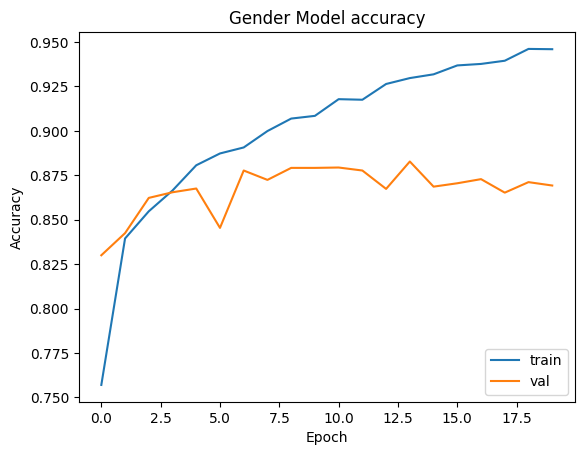

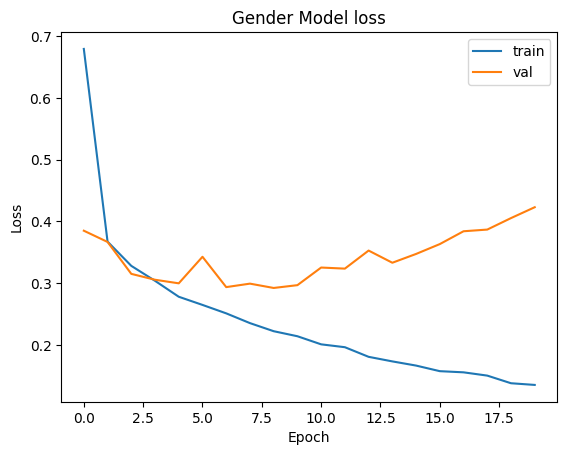

In [58]:
labels = data[['age', 'gender']].values
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

age_output = layers.Dense(104, activation='softmax', name='dense_age')(x)
gender_output = layers.Dense(2, activation='softmax', name='dense_gender')(x)

model = models.Model(inputs=inputs, outputs=[age_output, gender_output])

model.compile(optimizer='adam', loss={'dense_age': 'categorical_crossentropy', 'dense_gender': 'categorical_crossentropy'}, metrics=['accuracy'])

age = tf.keras.utils.to_categorical(y_train[:,0]//10, num_classes=104)
gender = tf.keras.utils.to_categorical(y_train[:,1], num_classes=2)

test_age = tf.keras.utils.to_categorical(y_val[:,0]//10, num_classes=104)
test_gender = tf.keras.utils.to_categorical(y_val[:,1], num_classes=2)

history = model.fit(X_train, {'dense_age': age, 'dense_gender': gender},
                    validation_data=(X_val, {'dense_age': test_age, 'dense_gender': test_gender}),
                    epochs=20, batch_size=64)

test_results = model.evaluate(X_val, {'dense_age': test_age, 'dense_gender': test_gender}, verbose=2)
print(f'Test accuracy: {test_results}')

import matplotlib.pyplot as plt

plt.plot(history.history['dense_age_accuracy'])
plt.plot(history.history['val_dense_age_accuracy'])
plt.title('Age Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['dense_age_loss'])
plt.plot(history.history['val_dense_age_loss'])
plt.title('Age Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history.history['dense_gender_accuracy'])
plt.plot(history.history['val_dense_gender_accuracy'])
plt.title('Gender Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['dense_gender_loss'])
plt.plot(history.history['val_dense_gender_loss'])
plt.title('Gender Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [59]:
model.save('/content/drive/MyDrive/age_gender.h5')